# HMDA Data: Summ. Stats., Visualizations, and OLS Reg. Analysis

## Exploratory Analysis with ```Pandas```, and statistical libraries for OLS Regression.
This notebook explores the Home Mortgage Disclosure Act (HMDA) data for one year -- 2017. Note that as of July 12, 2019, HMDA data is publically available for 2007 - 2017.
https://www.consumerfinance.gov/data-research/hmda/explore

In this notebook, we utilize ```pandas``` to visualize and clean data from the an AWS PostgreSQL Relational Database System. Afterwards it is also recommended that you complete the "additional_wrangling_challenge" notebook, which expands on these skills and is included in this course's repository.

**A README is under development to keep track of notes not included here and learning materials.** In addition, you may also find these resources helpful:  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/  
https://chrisalbon.com/python/data_wrangling/pandas_dataframe_descriptive_stats/
https://lectures.quantecon.org/py/ols.html

*There are many learning sources and prior work around similar topics: We draw inspiration from past Cohorts as well as learning materials from peer sources such as Kaggle and Towards Data Science*

---


## Importing Libraries and Loading the Data


First, we need to import all the libraries we are going to utilize throughout this notebook. We import everything at the very top of this notebook for order and best practice.

In [155]:
# Importing Libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import psycopg2
import pandas.io.sql as psql
import sqlalchemy
from sqlalchemy import create_engine

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from pylab import*
from matplotlib.ticker import LogLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

*-----*
 
Second, we establish the connection to the AWS PostgreSQL Relational Database System.

In [156]:
# Connecting to AWS PostgreSQL RDS.

engine_hmda_2017 = psycopg2.connect(
    database="paddle_loan_canoe",
    user="reporting_user",
    password="team_loan_canoe2019",
    host="aws-pgsql-loan-canoe.cr3nrpkvgwaj.us-east-2.rds.amazonaws.com",
    port='5432'
)


 *Note: A better way to do this is to define variables and put it into a function so you can easily call a specified engine, as seen below:*

In [157]:
# Postgres username, password, and database name.
postgres_host = 'aws-pgsql-loan-canoe.cr3nrpkvgwaj.us-east-2.rds.amazonaws.com'  
postgres_port = '5432' 
postgres_username = 'reporting_user' 
postgres_password = 'team_loan_canoe2019'
postgres_dbname = "paddle_loan_canoe"
postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'
                .format(username = postgres_username,
                        password = postgres_password,
                        host = postgres_host,
                        port = postgres_port,
                        dbname = postgres_dbname)
               )


# Creating the connection.
cnx = create_engine(postgres_str)

---

## Using Pandas:  Exploring the Data

In [158]:
#  Reading the HMDA 2017 dataset; join population and education datasets appropriately for 2017 
#  for the first 25,000 rows -- as a dataframe using pandas: df.

df = pd.read_sql_query ('''SELECT 
                              --> a. main: casting a few key MORTGAGE data fields:
                                   CAST(us17.action_taken_name As varchar(56)) As outcome, us17.as_of_year As year,
                                   CAST(denial_reason_name_1 As varchar(56)) dn_reason1 , CAST(us17.agency_name As varchar(56)) As agency,
                                   CAST(us17.state_name As varchar(28)) As state,         CAST(us17.county_name As varchar(56)) As county,
                                   CAST(us17.loan_type_name As varchar(56)) As ln_type,   CAST(us17.loan_purpose_name As varchar(56)) As ln_purp, 
                                   us17.loan_amount_000s As ln_amt_000s, us17.hud_median_family_income As hud_med_fm_inc, population as pop,

                                       --two embedded fuctions and one CASE below: assigns hierarchy in CASE, and converts to num in two steps
                                   CAST ( CAST ( CASE
                                                     WHEN us17.rate_spread = '' Then '0'
                                                     ELSE us17.rate_spread
                                                 END As varchar(5)
                                               ) As numeric
                                        )
                                   As rt_spread,
                                       --categorize loan application outcome into two buckets: "Approved", "Denied, Not Accepted, or Withdrawn"
                                   CASE
                                       WHEN us17.action_taken_name In ('Loan originated', 'Loan purchased by the institution')
                                           THEN 'Approved or Loan Purchased by the Institution'
                                       ELSE 'Denied, Not Accepted, or Withdrawn'
                                   END outcome_bucket,
                              --*
                              --> b. macro-econ: casting and joining a few key EDUCATION data fields:
                                   CAST(educ17."Perc_adults w_less than a HS diploma_2013-17" As int)  As prc_blw_HS__2013_17_5yrAvg,
                                   CAST(educ17."Perc_adults w_ HS diploma only_2013-17" As int)        As prc_HS__2013_17_5yrAvg,
                                   CAST(educ17."Perc_adults w_BA deg or higher_2013-17" As int)        As prc_BA_plus__2013_17_5yrAvg,
                              --*
                              --> c. macro-econ: casting and joining a few key POPULATION data fields:
                                   CAST(pop17.r_birth_2017 AS INT)                                     As r_birth_2017,
                                   CAST(pop17.r_international_mig_2017 AS INT)                         As r_intl_mig_2017,
                                   CAST(pop17.r_natural_inc_2017 AS INT)                               As r_natural_inc_2017
                              --*
                           FROM usa_mortgage_market.hmda_lar__2017 us17 
                           LEFT OUTER JOIN v__macro_economic_indicators.education__acs_1970_to_2017_5yravgs educ17 
                                   ON us17.county_name = educ17."Area name"
                           LEFT OUTER JOIN v__macro_economic_indicators.populationestimates__usda_ers_2010_to_2018 pop17
                                   ON us17.county_name = pop17.area_name
                           LIMIT 50000''', cnx)

# Using pandas to view the first 5 rows (NB: why does it start at 0?).
df.head(5)

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,outcome_bucket,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
0,Application withdrawn by applicant,2017,,Department of Housing and Urban Development,Virginia,Fairfax County,Conventional,Refinancing,75,107600,5352,0.0,"Denied, Not Accepted, or Withdrawn",8,13,61,NaN,NaN,NaN
1,Loan originated,2017,,Department of Housing and Urban Development,Connecticut,New Haven County,Conventional,Home purchase,120,84100,4701,0.0,Approved or Loan Purchased by the Institution,10,31,35,NaN,NaN,NaN
2,Application denied by financial institution,2017,Collateral,Consumer Financial Protection Bureau,Ohio,Portage County,Conventional,Refinancing,70,65700,7227,0.0,"Denied, Not Accepted, or Withdrawn",7,32,32,9.0,2.0,2.0
3,Application denied by financial institution,2017,Collateral,Consumer Financial Protection Bureau,Ohio,Portage County,Conventional,Refinancing,70,65700,7227,0.0,"Denied, Not Accepted, or Withdrawn",8,37,28,9.0,2.0,2.0
4,Application denied by financial institution,2017,Collateral,Consumer Financial Protection Bureau,Ohio,Portage County,Conventional,Refinancing,70,65700,7227,0.0,"Denied, Not Accepted, or Withdrawn",7,32,32,8.0,3.0,0.0


*Note: We can also easily use Pandas functionality to perform the joins in the SQL script being read above. See Pandas Cheat Sheet:* 
*https://pandas.pydata.org/*

In [144]:
# Using pandas to generate the summary statistics on the data.

df.info()# getting info first.

print(' ')
print('------------------------------------------')
print(' ')

df.describe(include = 'all')# next, top down describe the data; there are specific stats functions you can use with pandas. 
# ==> good tutorial: https://www.tutorialspoint.com/python_pandas/python_pandas_descriptive_statistics.htm.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
outcome                        50000 non-null object
year                           50000 non-null int64
dn_reason1                     50000 non-null object
agency                         50000 non-null object
state                          50000 non-null object
county                         50000 non-null object
ln_type                        50000 non-null object
ln_purp                        50000 non-null object
ln_amt_000s                    50000 non-null int64
hud_med_fm_inc                 50000 non-null int64
pop                            50000 non-null int64
rt_spread                      50000 non-null float64
outcome_bucket                 50000 non-null object
prc_blw_hs__2013_17_5yravg     50000 non-null int64
prc_hs__2013_17_5yravg         50000 non-null int64
prc_ba_plus__2013_17_5yravg    50000 non-null int64
r_birth_2017                   49048 non-null flo

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,outcome_bucket,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
count,50000,50000.0,50000,50000,50000,50000,50000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000,50000.000000,50000.00000,50000.000000,49048.000000,49048.000000,49048.000000
unique,6,NaN,9,6,35,182,4,3,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,Loan originated,NaN,,Department of Housing and Urban Development,Kentucky,Jefferson County,Conventional,Home purchase,NaN,NaN,NaN,NaN,Approved or Loan Purchased by the Institution,NaN,NaN,NaN,NaN,NaN,NaN
freq,27841,NaN,44026,23751,11428,17575,36105,24175,NaN,NaN,NaN,NaN,33524,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,182.804600,70419.236000,4732.751900,0.056139,NaN,12.792920,33.87190,22.968380,10.942159,0.892146,0.217420
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,306.722436,13185.475733,2263.316829,0.383352,NaN,5.624848,7.41657,10.284091,2.110777,2.274160,3.419726
min,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,42800.000000,1086.000000,0.000000,NaN,2.000000,12.00000,8.000000,5.000000,-1.000000,-10.000000
25%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,101.000000,62600.000000,3772.000000,0.000000,NaN,9.000000,29.00000,16.000000,9.000000,0.000000,-2.000000
50%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,151.000000,65600.000000,4586.000000,0.000000,NaN,12.000000,34.00000,20.000000,11.000000,0.000000,1.000000
75%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,229.000000,74500.000000,5428.000000,0.000000,NaN,16.000000,39.00000,30.000000,12.000000,1.000000,2.000000


In [145]:
# Using pandas to generate the number of unique values for loan outcome.

df['outcome'].value_counts()

Loan originated                                27841
Application denied by financial institution     7234
Application withdrawn by applicant              6060
Loan purchased by the institution               5683
Application approved but not accepted           1673
File closed for incompleteness                  1509
Name: outcome, dtype: int64

In [159]:
# Using pandas to generate the number of unique values for loan outcome, grouped by the agency deciding the loan outcome.

df.groupby('agency')['outcome'].value_counts()

agency                                       outcome                                    
Consumer Financial Protection Bureau         Application denied by financial institution    5884
                                             Loan originated                                4370
                                             Loan purchased by the institution              2960
                                             Application withdrawn by applicant              891
                                             Application approved but not accepted            73
                                             File closed for incompleteness                   36
Department of Housing and Urban Development  Loan originated                                8623
                                             Application withdrawn by applicant             4690
                                             Application denied by financial institution    4123
                                      

---

## Using Pandas: Visualizing the Data


First, we generate a simple histogram of the ```Loan Amount``` data, setting the ```bins = 50```, so we can see the distrubtion in somewhat finer detail.

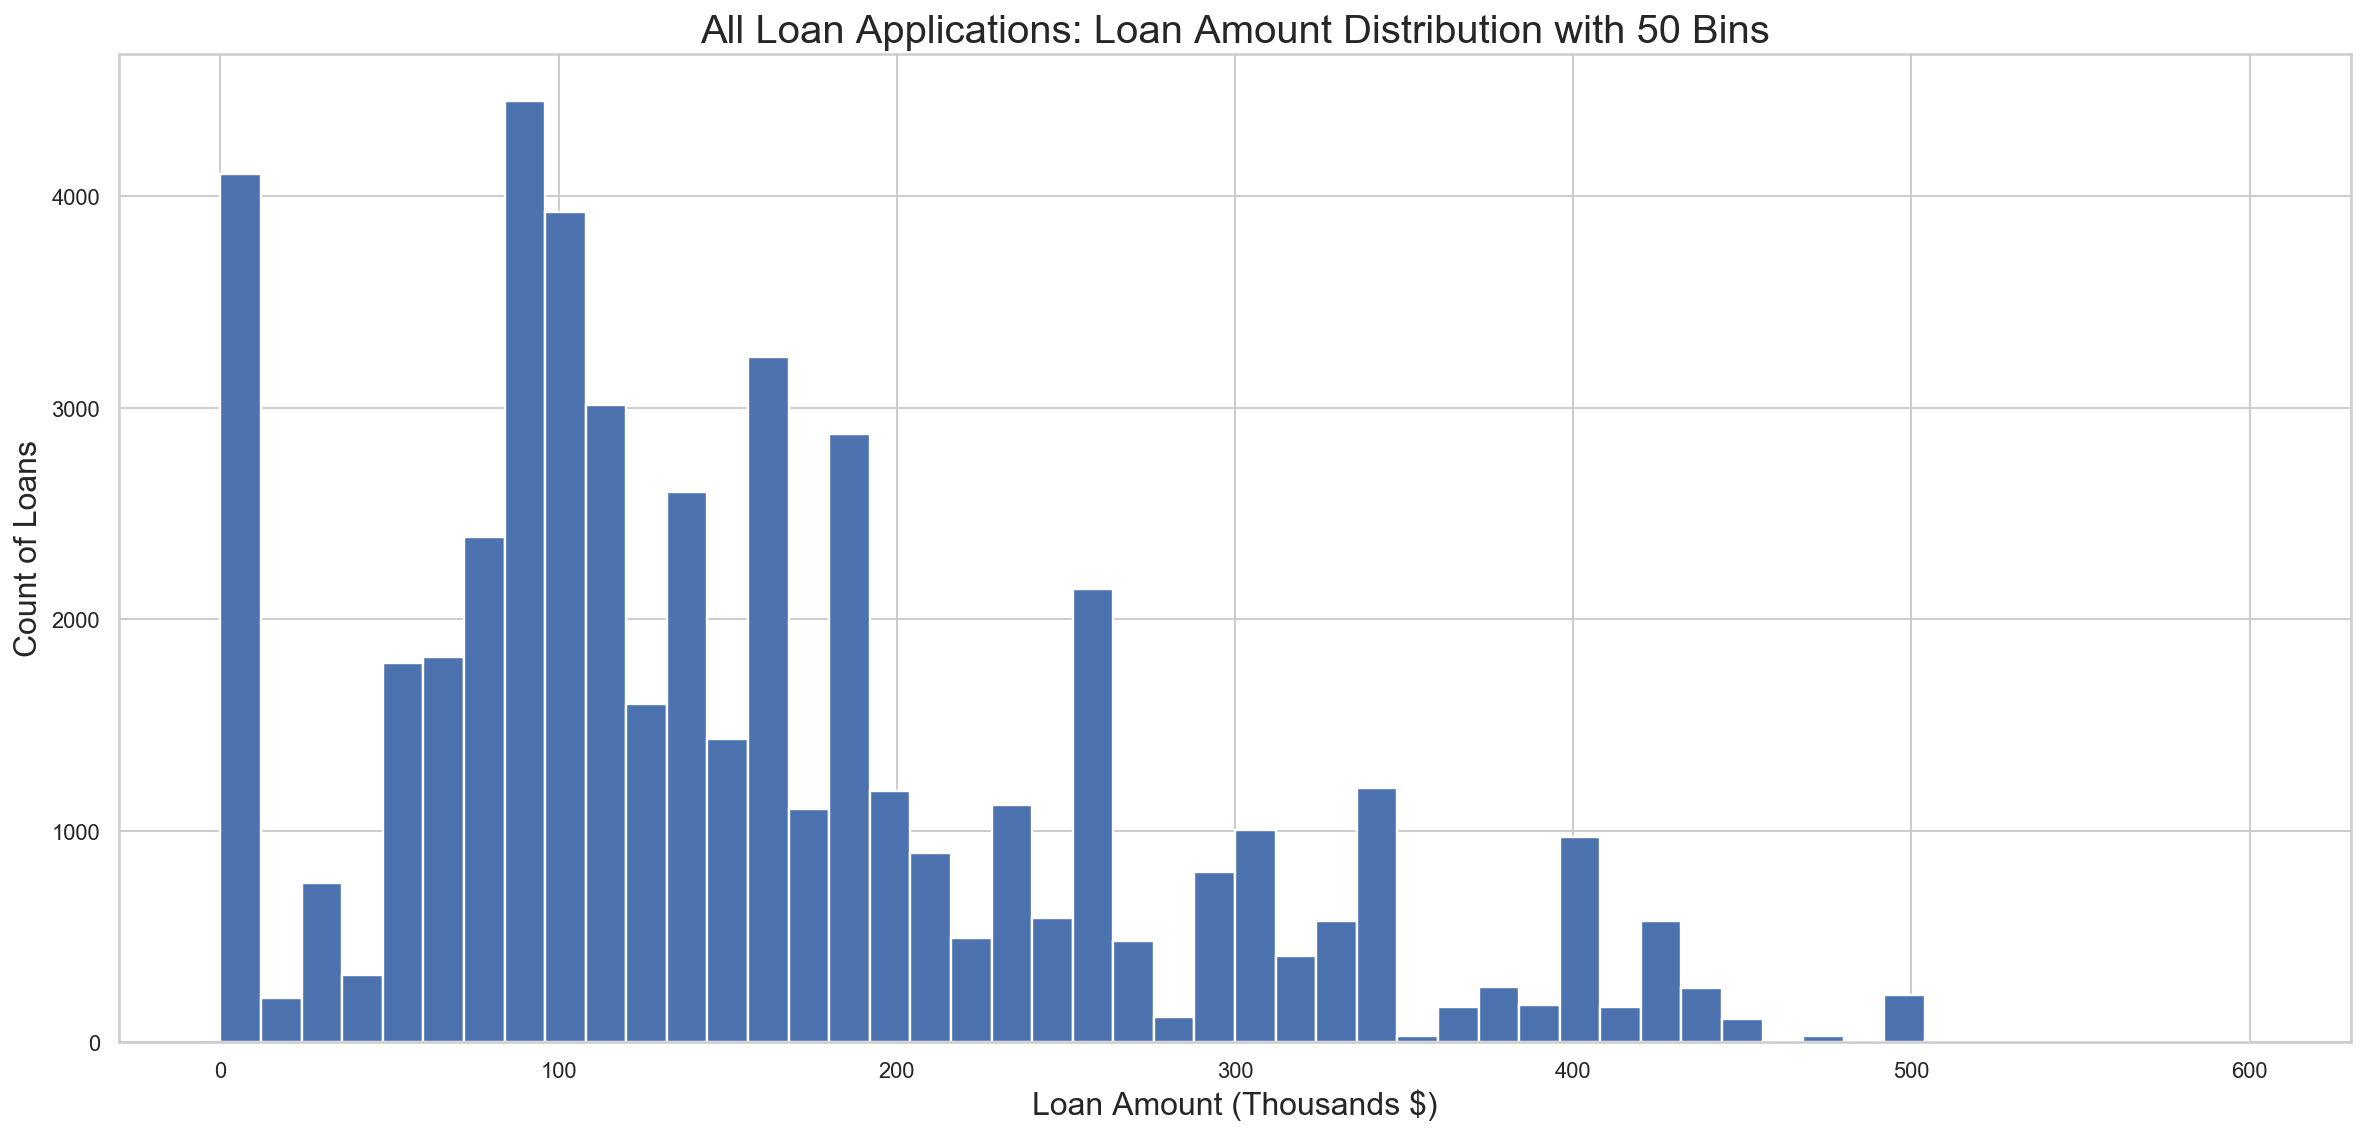

 
---
 


In [160]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(212)                                                 # default --> range=(df['Fare'].min(),df['Fare'].max())
ax.hist(df['ln_amt_000s'], bins=50, edgecolor = 'white', linewidth = 1.2, range=[0, 600])

plt.title('All Loan Applications: Loan Amount Distribution with 50 Bins', fontsize = 20)
plt.xlabel('Loan Amount (Thousands $)', fontsize = 16)
plt.ylabel('Count of Loans', fontsize = 16)
plt.show()

print(' ')
print('---')
print(' ')

Next, we employe ```seaborn``` to create distribution plots.

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income


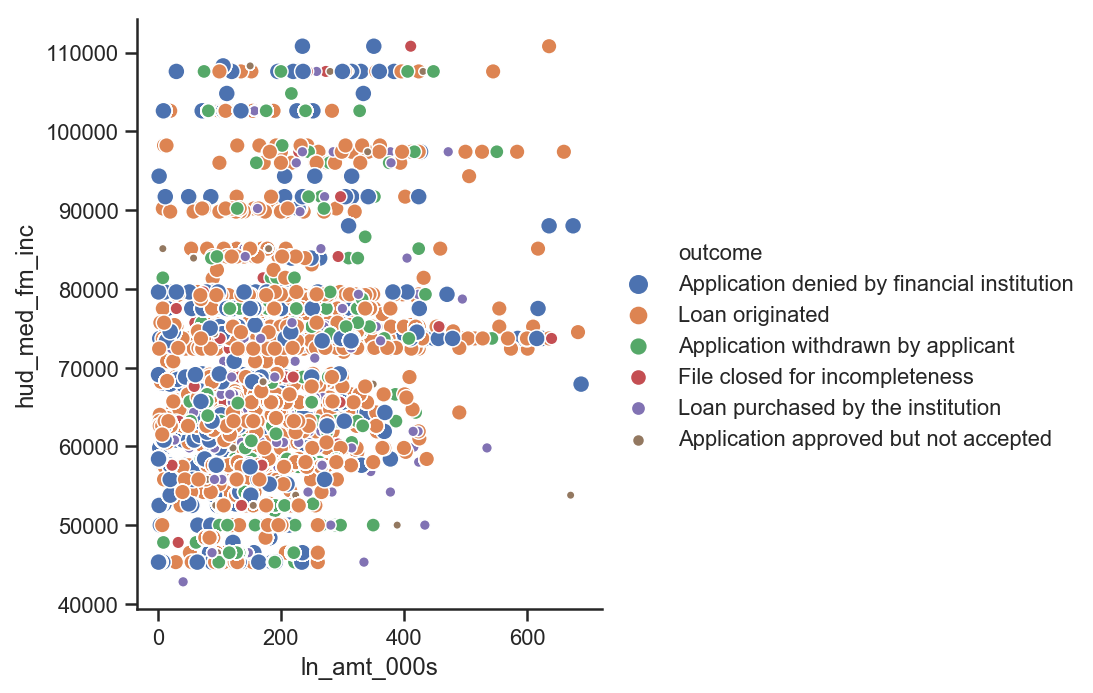

In [148]:
# All in one scatter plot, colored by loan outcome.

    # --> Drawing a single facet to use the FacetGrid legend placement.
sns.set(style = 'ticks')
df2 = (df[df.ln_amt_000s < 700])
g = sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', hue = 'outcome', 
                size = 'outcome', data = df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income')

*Note: ```sns.relplot``` is a "Figure-level interface for drawing relational plots onto a FacetGrid". See API: https://seaborn.pydata.org/generated/seaborn.relplot.html.*

In [149]:
# Limit our prelimary analysis to just loan applications for $700K or less, set seaborn style to whitegrid

df2 = df[df.ln_amt_000s < 700].fillna('')
sns.set_style('whitegrid')

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose


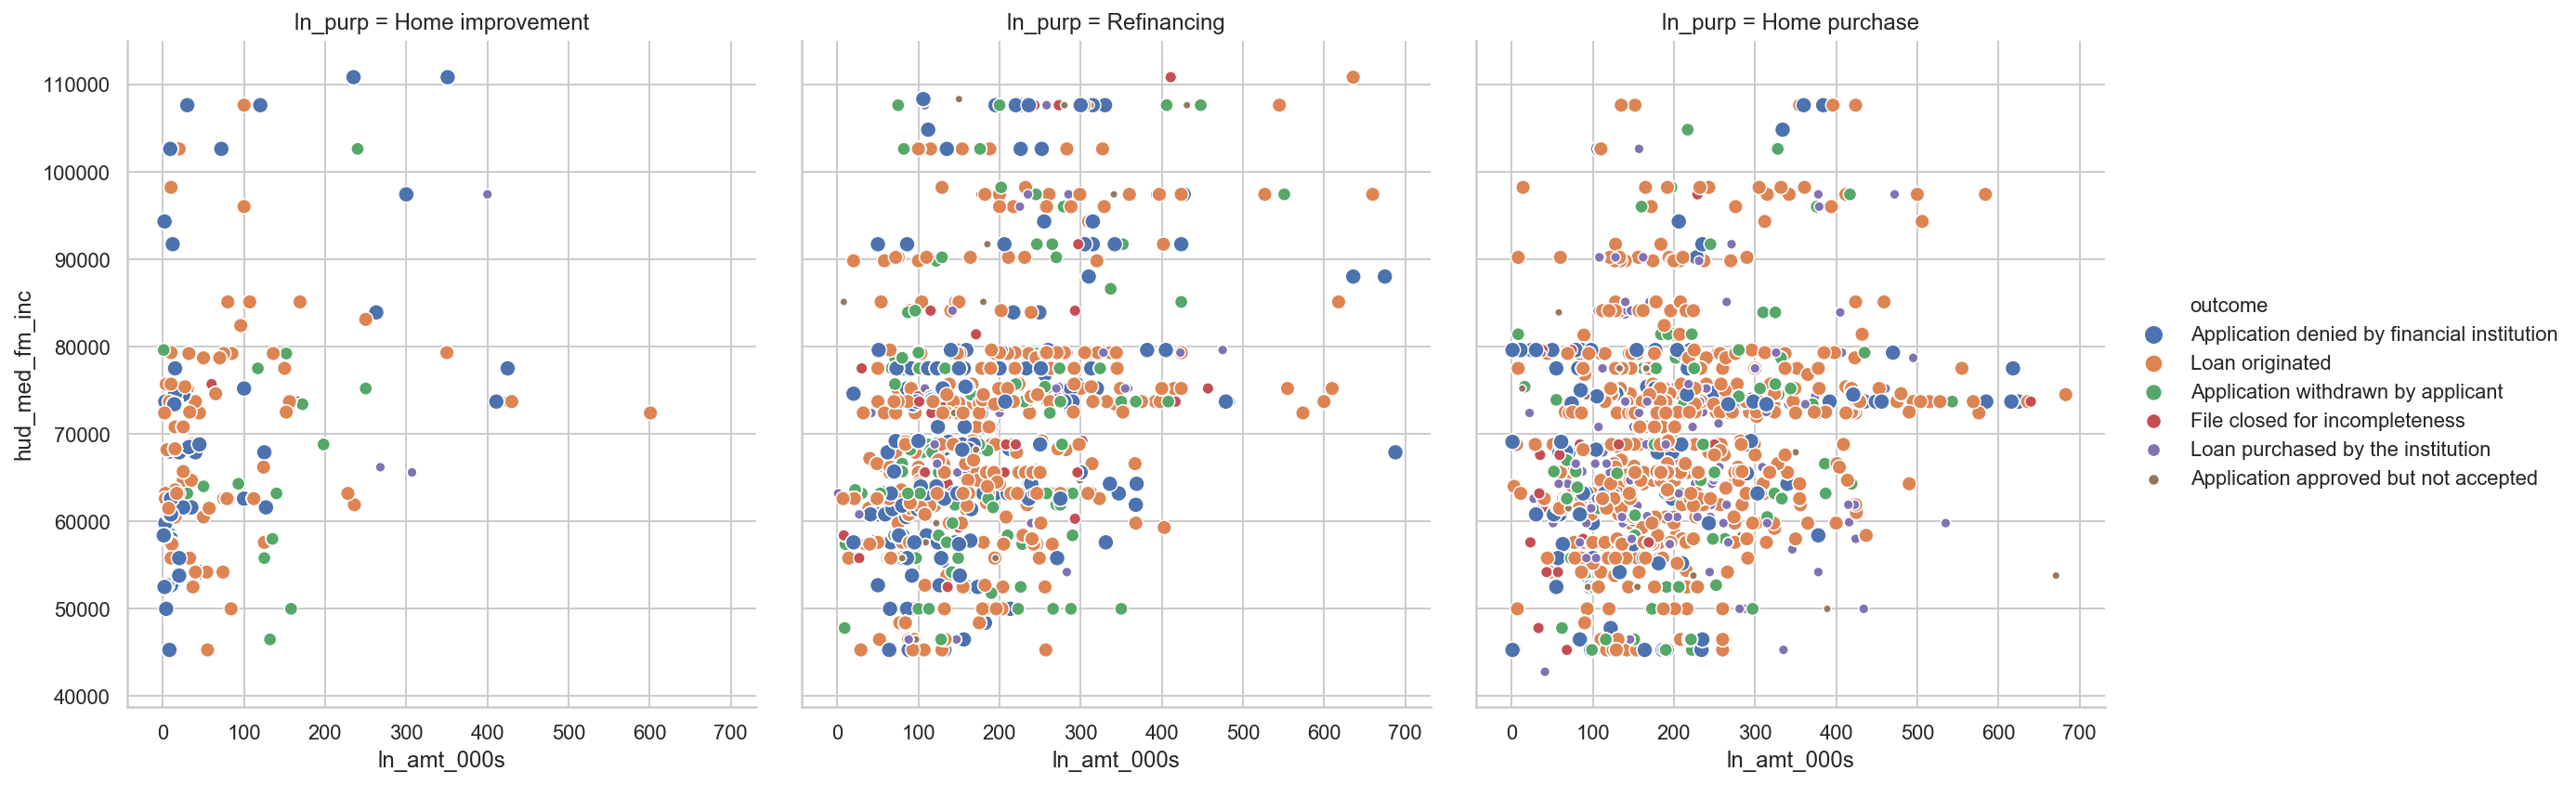

In [150]:
# Grouped by Loan Purpose.

    # --> Drawing scatter plots for multiple column with another variable.
g = sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', col = 'ln_purp', hue = 'outcome', 
                size = 'outcome', height = 6, aspect = 0.9, legend = 'brief', data = df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose')

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose and Loan Type


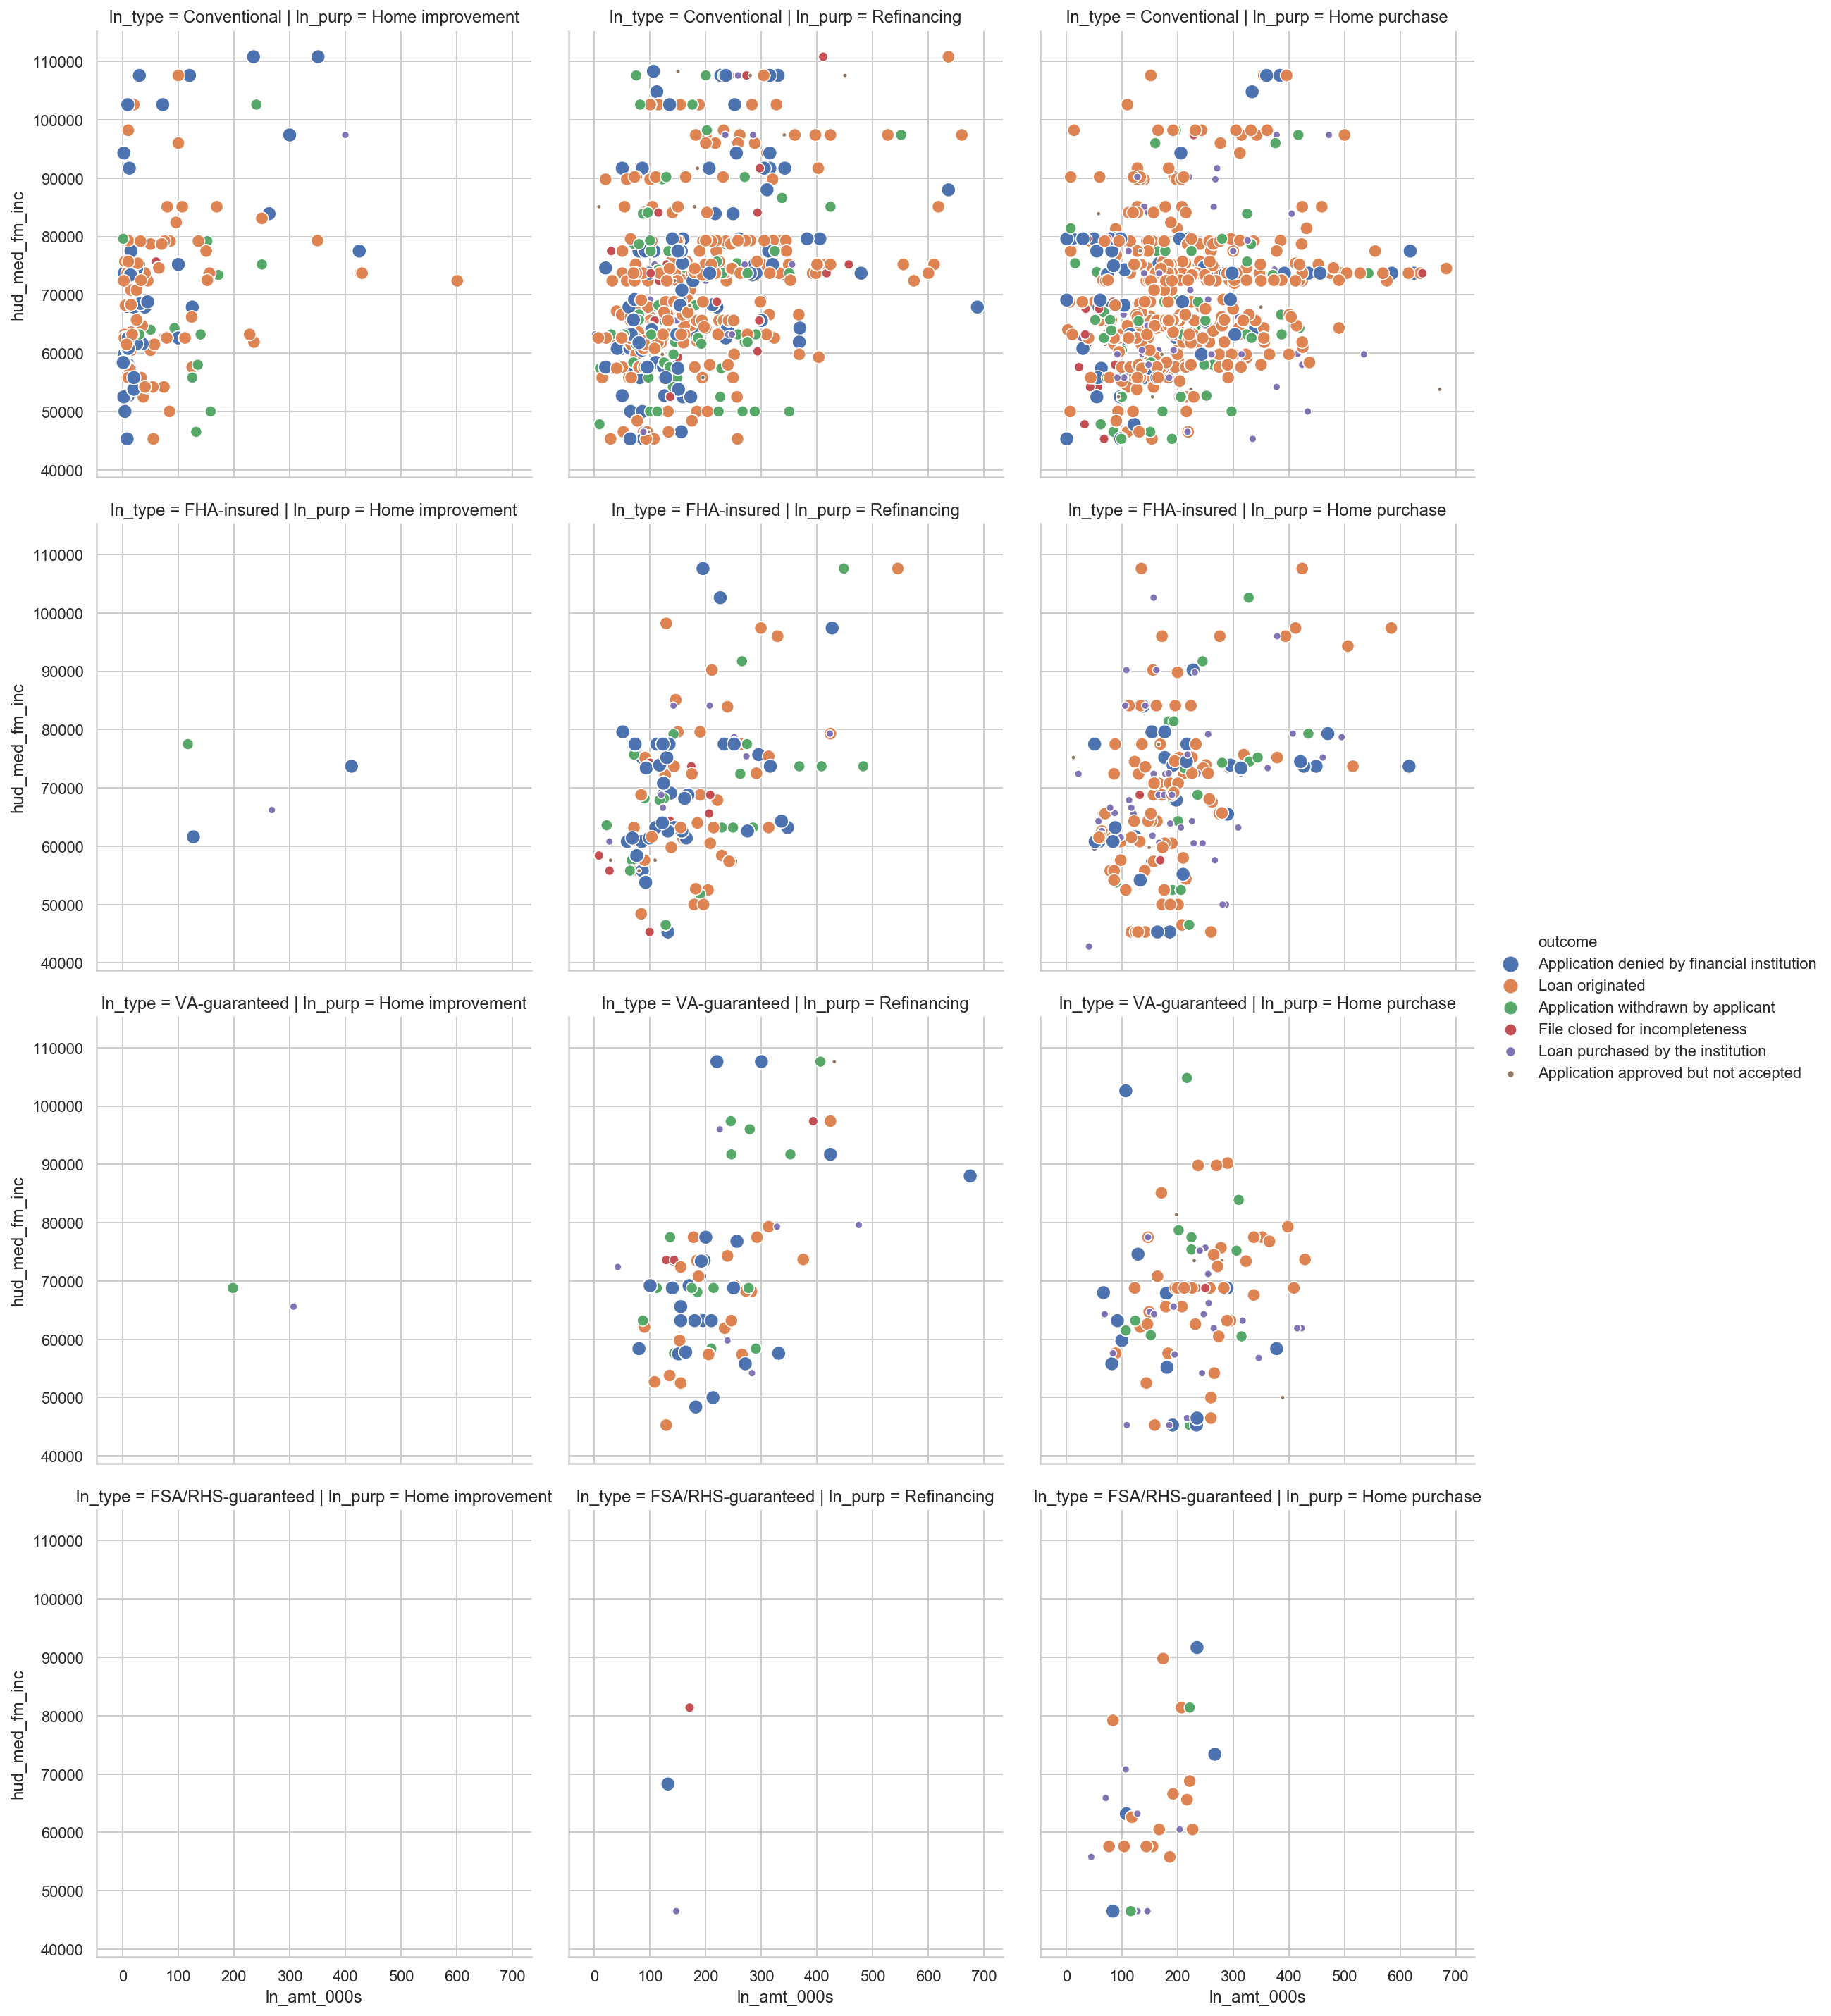

In [152]:
# Grouped by Loan Purpose and Loan Type.

    # --> Drawing scatter plots that facet on columns, and rows, with another variable.
g = sns.relplot(x='ln_amt_000s', y='hud_med_fm_inc', col='ln_purp', row='ln_type',
                hue='outcome', size='outcome', sizes=(10,100), legend='brief', data=df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose and Loan Type')

 
Loan Application Outcome: Shaded Line Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose


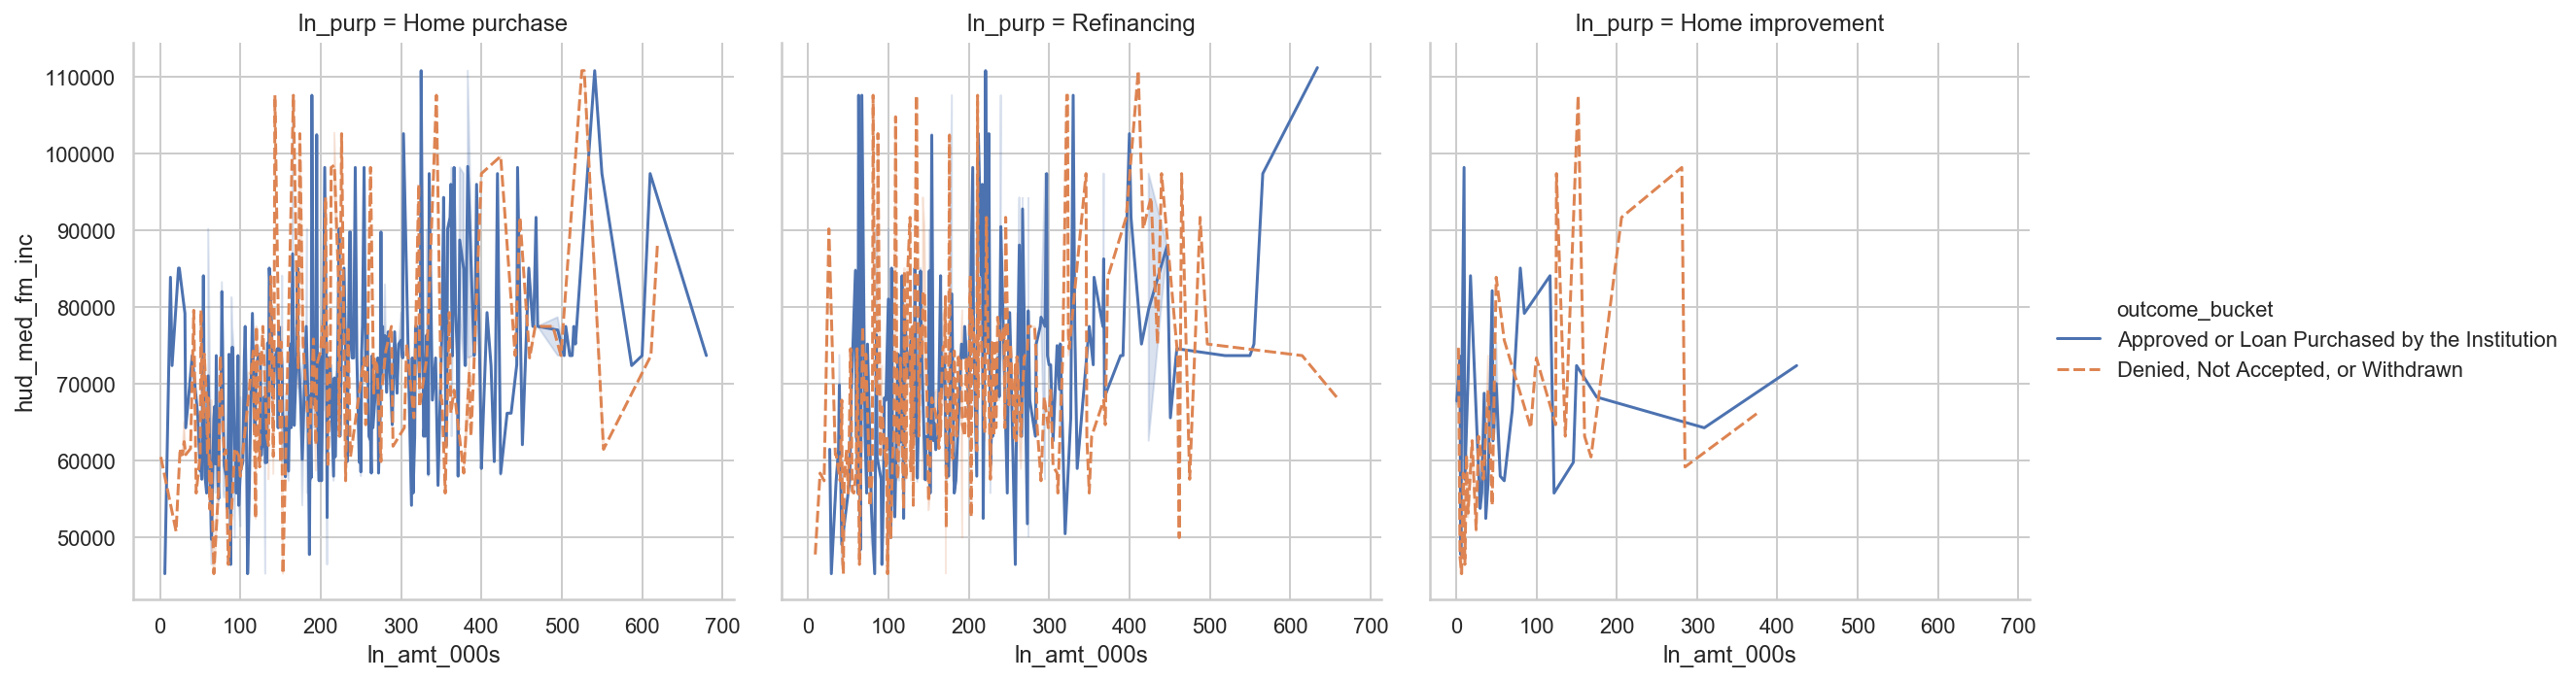

In [130]:
# Using a differnt kind of plot.

    # --> Drawing shaded line plot -- generating shaded areas of dispersion -- that facet on columns with another variable.
dash_styles = ["",
               (4, 1.5),
               (1, 1)]
g = sns.relplot(x='ln_amt_000s', y='hud_med_fm_inc', col='ln_purp', hue='outcome_bucket', 
                style='outcome_bucket', dashes = dash_styles, kind = 'line', legend='brief', data=df2)
print(' ')
print('Loan Application Outcome: Shaded Line Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose')

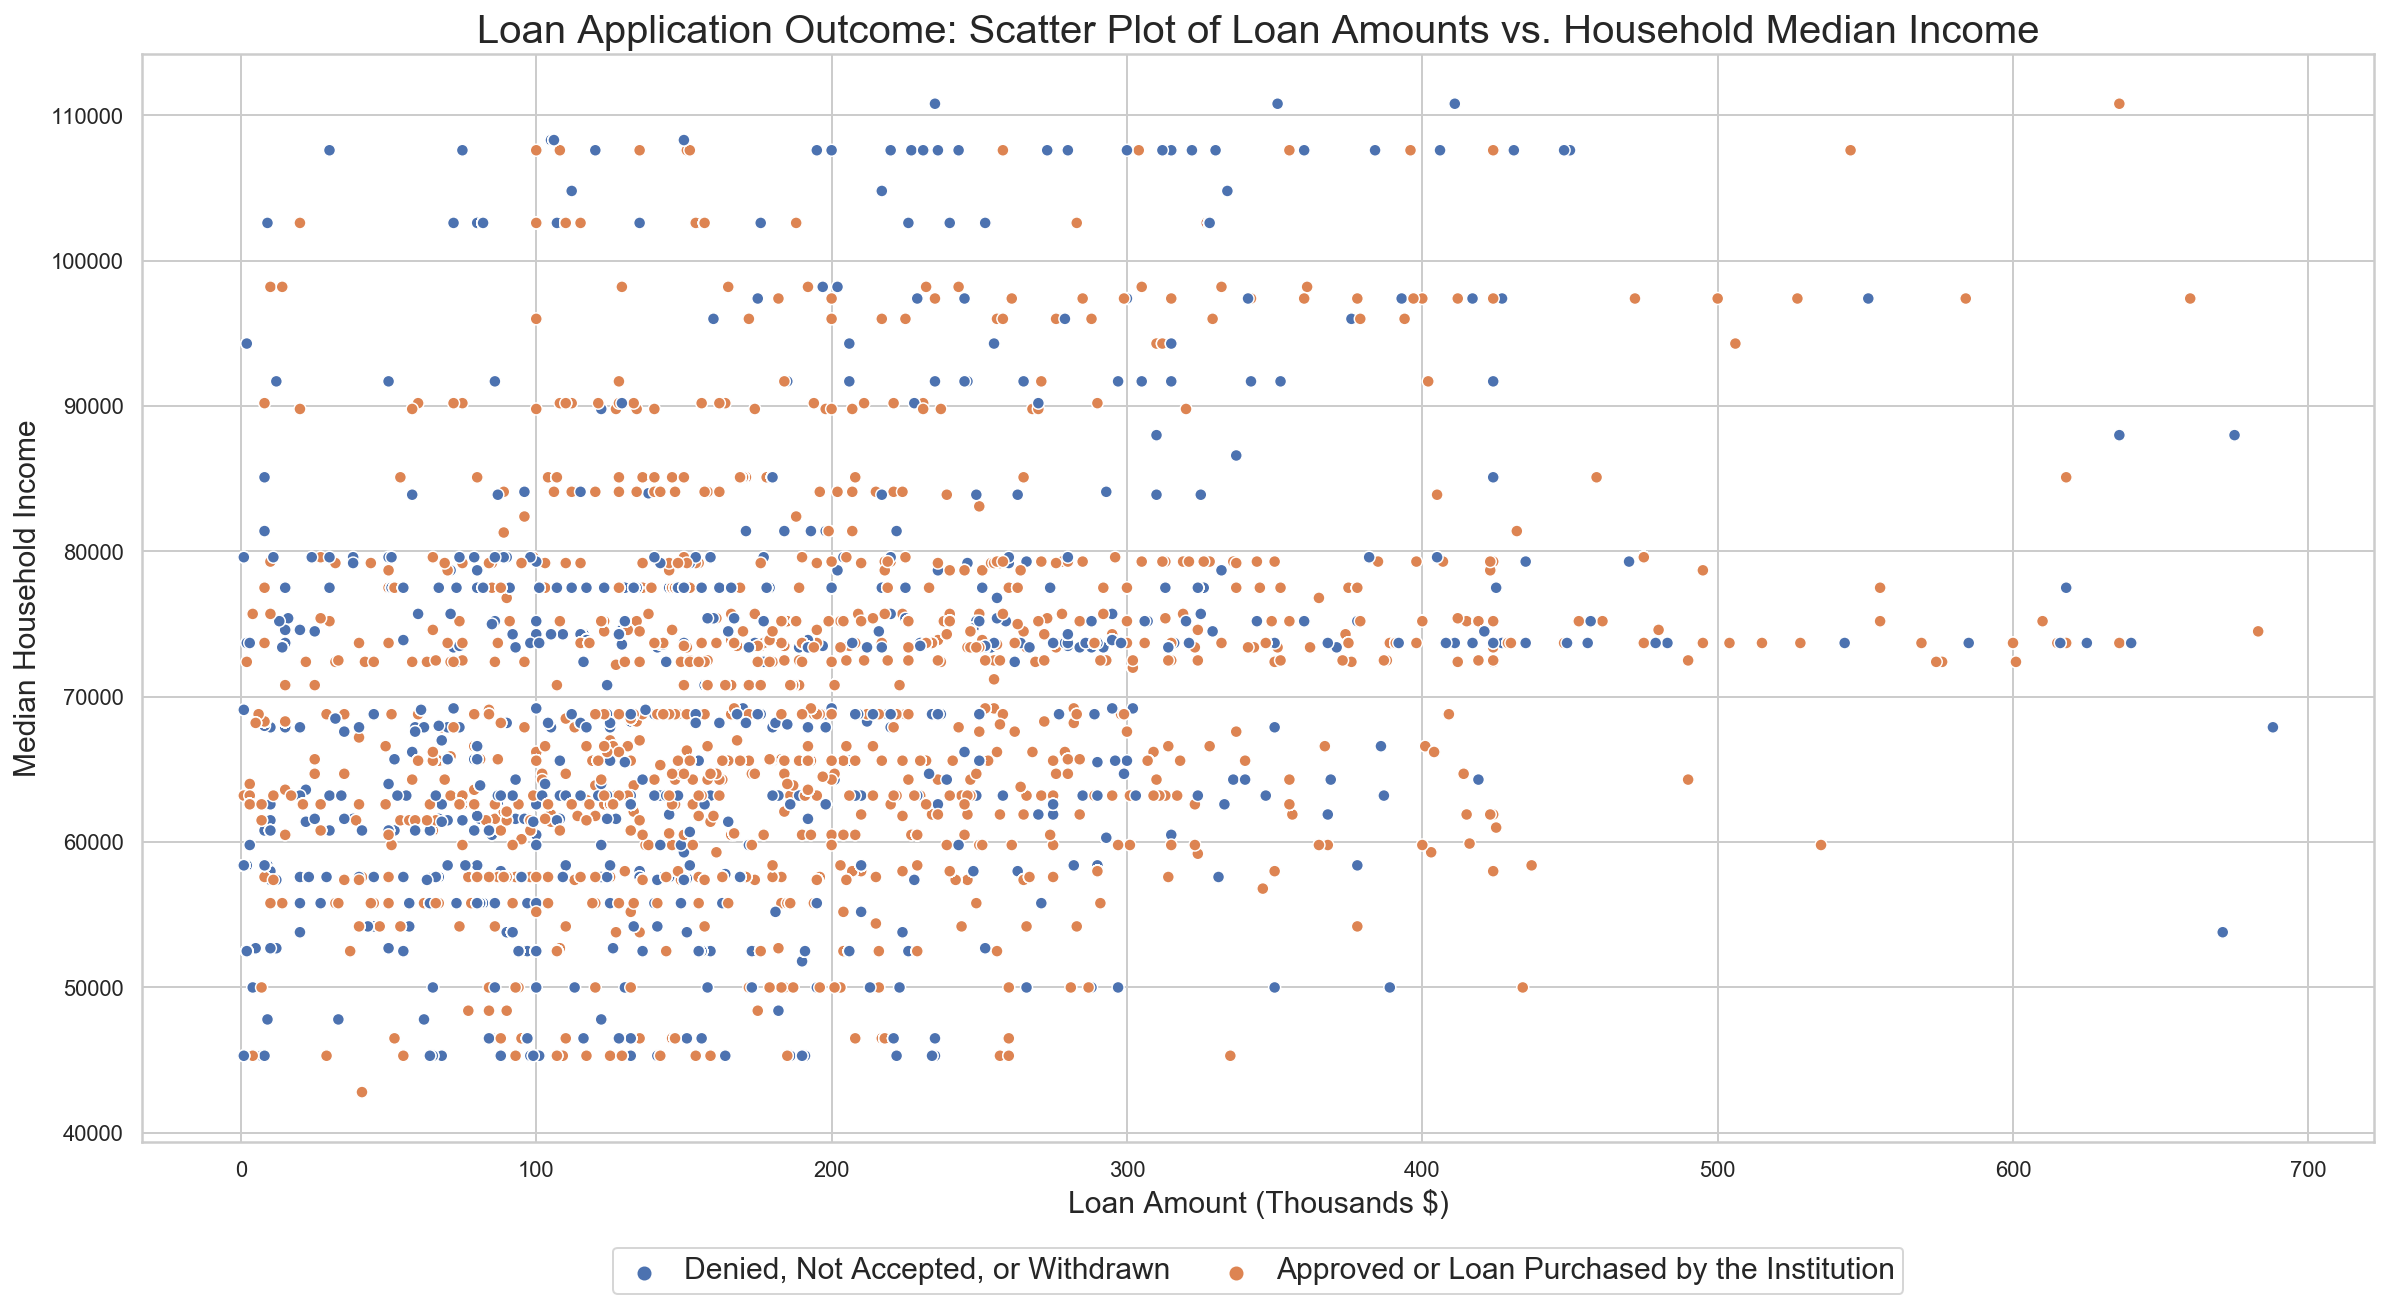

In [153]:
# Using a simple sns.scatterplot instead allowing us to tweak Seaborn scatter plot legends.

df2 = df[df.ln_amt_000s<700]

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x= 'ln_amt_000s', y='hud_med_fm_inc', hue='outcome_bucket',
                legend='brief', ax=ax, data = df2)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:], 
          loc=8, ncol=2, bbox_to_anchor=[0.5,-.15,0,0])

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text;   
                                                     # for legend title --> #plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.title('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income', fontsize='20')
plt.xlabel('Loan Amount (Thousands $)', fontsize='15')
plt.ylabel('Median Household Income', fontsize='15')
plt.show()


---


## Data Wrangling
It's important for us to wrangle our data before building our models, since ```scikit-learn``` cannot process missing values and only accepts numerical data. We also deal with outliers beforehand, since they will overwhelmingly negatively impact the peformance of our machine learning models.


### Outliers
Note that we have limited our prelimary analysis to just loan applications for ```$700K or less```. Since there is a relationship between the the median household income and the loan outcome bucket, we investigate the outliers in the data further in a boxplot.

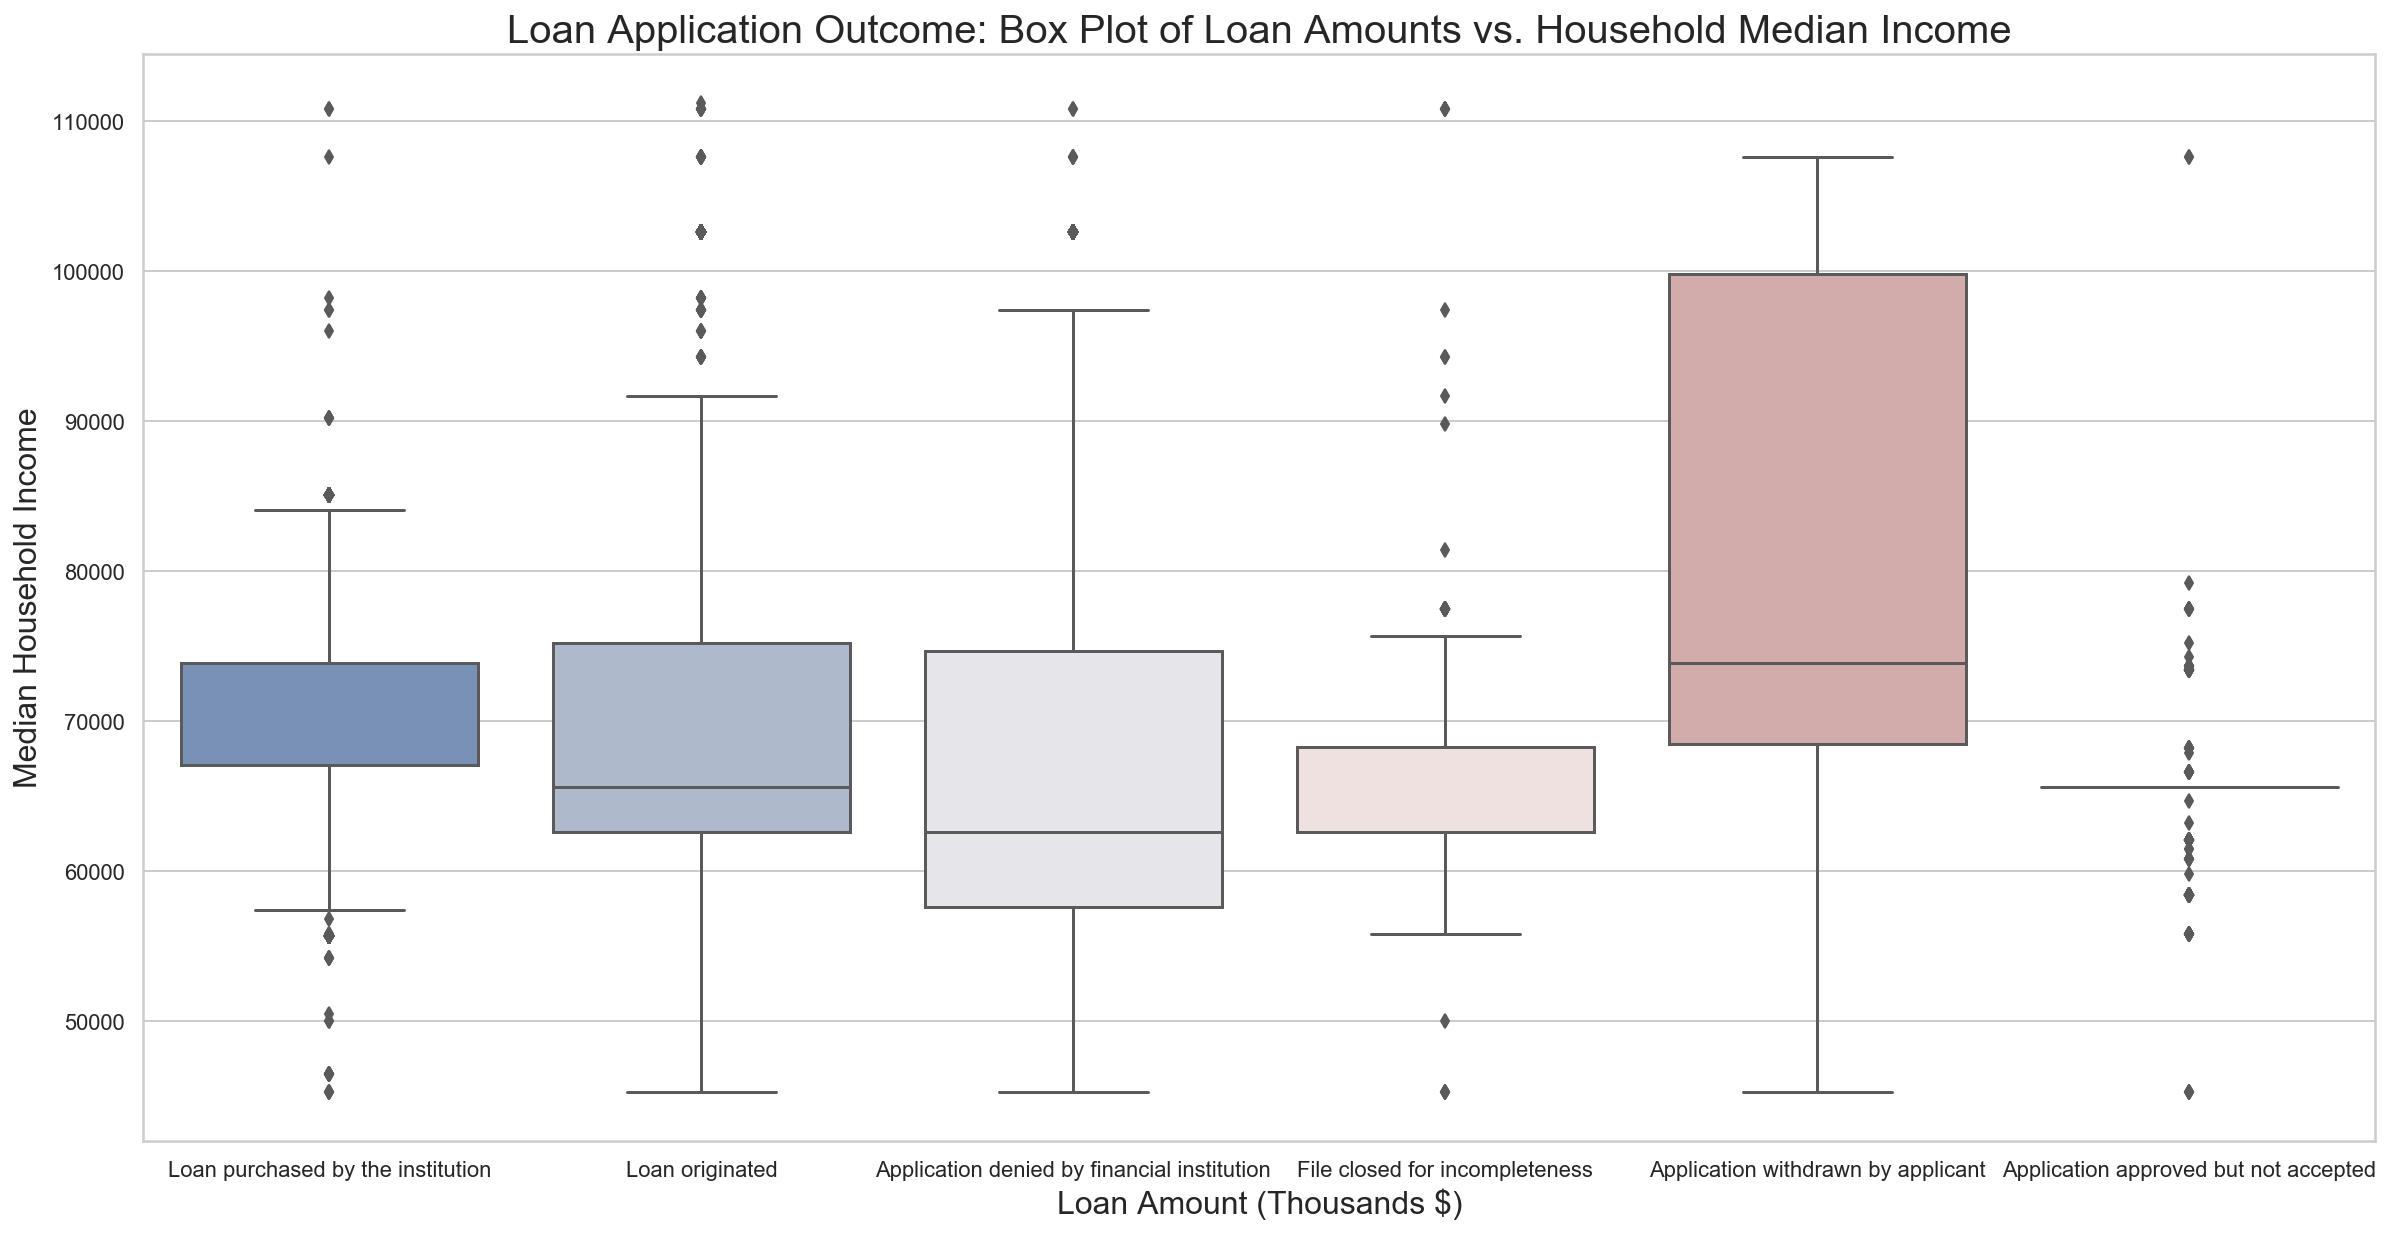

 
---
 


In [132]:
f, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='outcome', y='hud_med_fm_inc', data=df2, palette='vlag')

plt.title('Loan Application Outcome: Box Plot of Loan Amounts vs. Household Median Income', fontsize=20)
plt.xlabel('Loan Amount (Thousands $)', fontsize=16)
plt.ylabel('Median Household Income', fontsize=16)
plt.show()

print(' ')
print('---')
print(' ')

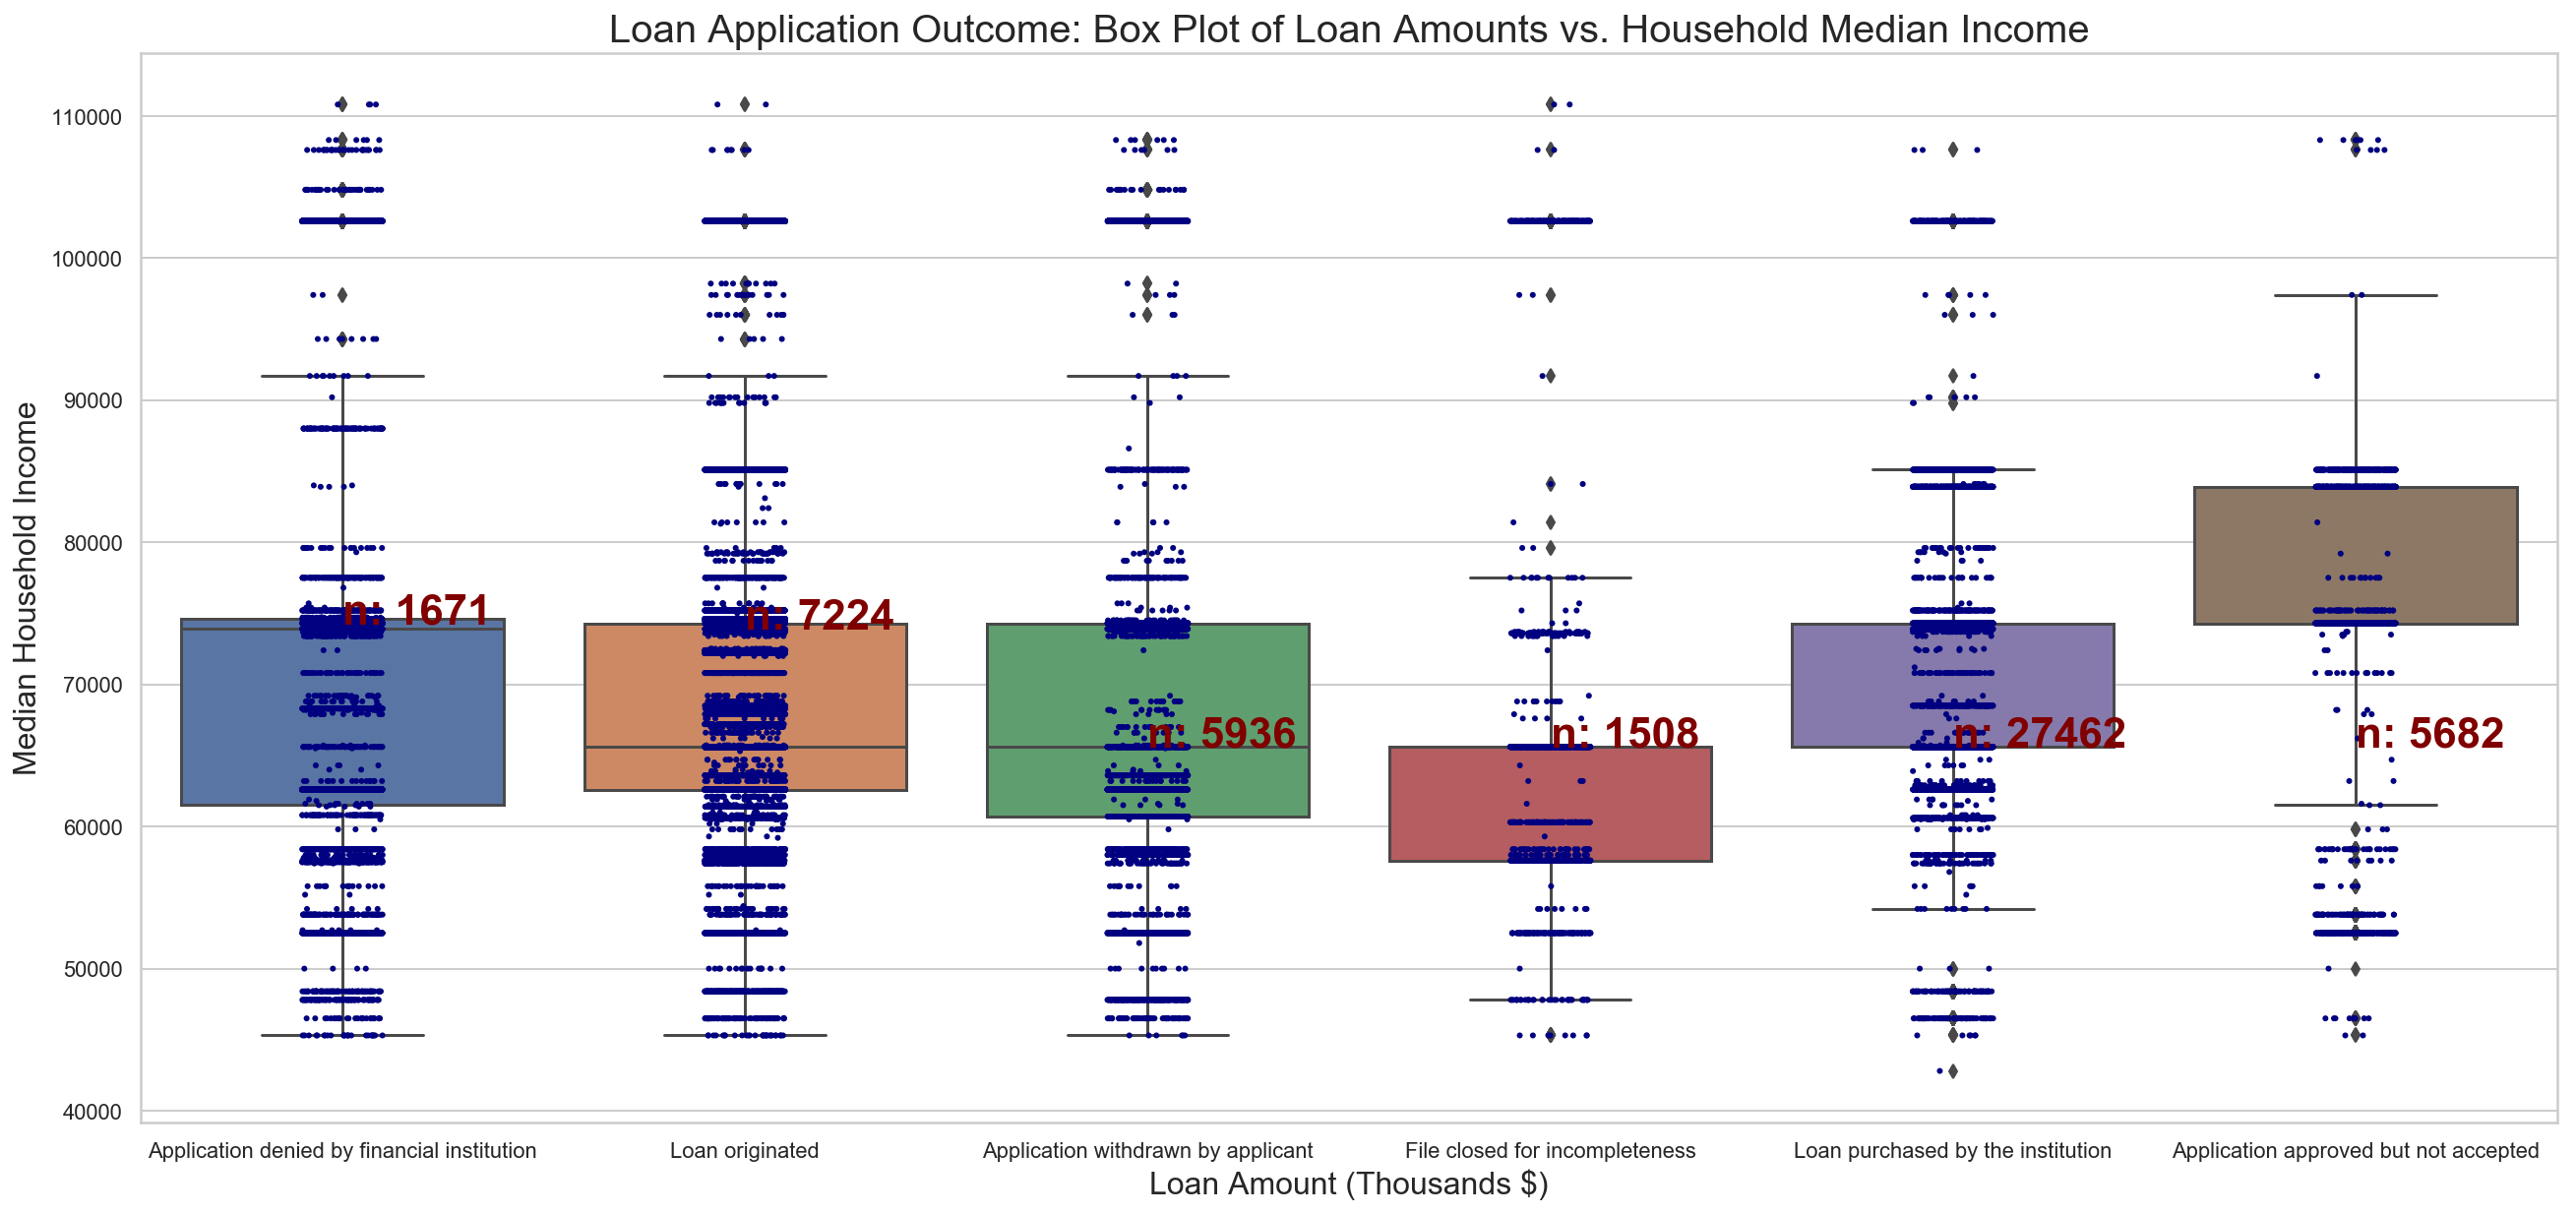

In [154]:
# Create a more robust boxplot to see the distrubtion of scatters and the number of observations for each box.

f, ax = plt.subplots(figsize=(22,10))

    # --> Starting with a standard boxplot and stripplot with jitters.
sns.boxplot(x='outcome', y='hud_med_fm_inc', data=df2)
sns.stripplot(x='outcome', y='hud_med_fm_inc', data=df2, color="navy", jitter=0.1, size=3.0)

    # --> Calculating the number of obs per group & median to position labels.
medians = df2.groupby(['outcome'])['hud_med_fm_inc'].median().values
nobs = df2.groupby("outcome").size().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: "+i for i in nobs]

    # --> Adding it to the plot.
pos=range(len(nobs)) 
for tick,label in zip(pos,ax.get_xticklabels()):
    plt.text(pos[tick], medians[tick]+0.4, nobs[tick], 
             horizontalalignment='left', size=22, color='maroon', weight='semibold')
    
    # --> showing the visualizationg 
plt.title("Boxplot with jitter")
plt.title('Loan Application Outcome: Box Plot of Loan Amounts vs. Household Median Income', fontsize=20)
plt.xlabel('Loan Amount (Thousands $)', fontsize=16)
plt.ylabel('Median Household Income', fontsize=16)
plt.show()


Note, we can see right away that there are a number of loan application that are linked to households with notably higher median household incomes. They fall far outside the upper whisker. Next, we sort the data by median household income so we can see a the data in tabular form.

In [161]:
df2.sort_values(by='hud_med_fm_inc', ascending=False).head(10)

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,outcome_bucket,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
4046,File closed for incompleteness,2017,,Consumer Financial Protection Bureau,New York,Nassau County,Conventional,Refinancing,411,110800,4438,0.0,"Denied, Not Accepted, or Withdrawn",9,33,27,10.0,0.0,-1.0
37770,Application denied by financial institution,2017,Credit history,National Credit Union Administration,New York,Nassau County,Conventional,Home improvement,235,110800,2664,0.0,"Denied, Not Accepted, or Withdrawn",9,33,27,10.0,0.0,-1.0
37769,Application denied by financial institution,2017,Credit history,National Credit Union Administration,New York,Nassau County,Conventional,Home improvement,235,110800,2664,0.0,"Denied, Not Accepted, or Withdrawn",9,23,44,10.0,0.0,-1.0
29257,Application denied by financial institution,2017,Debt-to-income ratio,Consumer Financial Protection Bureau,New York,Nassau County,Conventional,Home improvement,351,110800,2664,0.0,"Denied, Not Accepted, or Withdrawn",9,33,27,10.0,0.0,-1.0
29256,Application denied by financial institution,2017,Debt-to-income ratio,Consumer Financial Protection Bureau,New York,Nassau County,Conventional,Home improvement,351,110800,2664,0.0,"Denied, Not Accepted, or Withdrawn",9,23,44,10.0,0.0,-1.0
32806,Loan originated,2017,,Department of Housing and Urban Development,New York,Nassau County,Conventional,Refinancing,636,110800,2664,0.0,Approved or Loan Purchased by the Institution,9,33,27,10.0,0.0,-1.0
32805,Loan originated,2017,,Department of Housing and Urban Development,New York,Nassau County,Conventional,Refinancing,636,110800,2664,0.0,Approved or Loan Purchased by the Institution,9,23,44,10.0,0.0,-1.0
4045,File closed for incompleteness,2017,,Consumer Financial Protection Bureau,New York,Nassau County,Conventional,Refinancing,411,110800,4438,0.0,"Denied, Not Accepted, or Withdrawn",9,23,44,10.0,0.0,-1.0
40647,Application withdrawn by applicant,2017,,Federal Deposit Insurance Corporation,Connecticut,Fairfield County,Conventional,Refinancing,105,108300,5314,0.0,"Denied, Not Accepted, or Withdrawn",8,34,27,11.0,1.0,3.0
45181,Application approved but not accepted,2017,,Department of Housing and Urban Development,Connecticut,Fairfield County,Conventional,Refinancing,150,108300,6342,0.0,"Denied, Not Accepted, or Withdrawn",8,34,27,11.0,1.0,3.0


Since the ``` > $100K``` median household incomes appear to be outliers, we'll replace them with ```= $91K```, since it is the top of the upper wishker and therefore falls within the last quartile. Note, this is for preliminary modeling only and could not "standardized" so simply in our final model.

In [166]:
for idx in df2.index:
    if df2.loc[idx].hud_med_fm_inc > 91000:
        df2.set_value(idx, 'hud_med_fm_inc', 91000)

In [165]:
# Displaying top 5 rows by Median Household Income to see that our replace loop above worked.
df2.sort_values(by='hud_med_fm_inc', ascending=False).head(5)

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,outcome_bucket,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
49999,Application denied by financial institution,2017,Collateral,Department of Housing and Urban Development,Pennsylvania,Montgomery County,Conventional,Refinancing,135,91000,4165,0.0,"Denied, Not Accepted, or Withdrawn",10,28,27,14.0,0.0,2.0
20370,Loan originated,2017,,Federal Deposit Insurance Corporation,Pennsylvania,Montgomery County,Conventional,Refinancing,115,91000,4165,0.0,Approved or Loan Purchased by the Institution,8,29,26,12.0,1.0,1.0
20368,Loan originated,2017,,Federal Deposit Insurance Corporation,Pennsylvania,Montgomery County,Conventional,Refinancing,115,91000,4165,0.0,Approved or Loan Purchased by the Institution,8,23,46,12.0,1.0,1.0
20367,Loan originated,2017,,Federal Deposit Insurance Corporation,Pennsylvania,Montgomery County,Conventional,Refinancing,115,91000,4165,0.0,Approved or Loan Purchased by the Institution,14,26,32,12.0,1.0,-2.0
20366,Loan originated,2017,,Federal Deposit Insurance Corporation,Pennsylvania,Montgomery County,Conventional,Refinancing,115,91000,4165,0.0,Approved or Loan Purchased by the Institution,21,37,12,12.0,1.0,-2.0


### Dealing with Missing Data
We know want to decide how to handle missing values, and so we first need to know how prevalent they are in this subset dataset. We use```pandas``` to find out how many values for ```Median Household Income``` are missing from our data set.

__=>__ Use ```pandas``` to get the sum of all the null values in the ```Median Household Income``` column.

Documentation:    
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.isnull.html    
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sum.html

In [168]:
# Sum the number of null Cabin values.

len(df2) - df2['hud_med_fm_inc'].count()

0

In [172]:
# Here is a more detailed view of what data is missing.

total = df2.isnull().sum().sort_values(ascending=False)
percent_1 = df2.isnull().sum()/df2.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
r_natural_inc_2017,936,1.9
r_birth_2017,936,1.9
r_intl_mig_2017,936,1.9
ln_purp,0,0.0
year,0,0.0


### Deleting a Feature
__=>__ Since about 2% of the ```r_``` data values are missing, let's use ```pandas``` to drop the rows with missing values in these from these specific columns. 

Documentation:  
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html  
https://chrisalbon.com/python/pandas_dropping_column_and_rows.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [176]:
df2.dropna(subset=['r_natural_inc_2017', 'r_birth_2017', 'r_intl_mig_2017'], inplace=True)

  # --> Checking the result to see that the missing data has been dropped
total = df2.isnull().sum().sort_values(ascending=False)
percent_1 = df2.isnull().sum()/df2.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
r_natural_inc_2017,0,0.0
ln_amt_000s,0,0.0
year,0,0.0
dn_reason1,0,0.0
agency,0,0.0
